In [54]:
%pylab inline

%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.integrate import simps
from time import time
import os, sys

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov', 'time', 'beta', 'loads']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [55]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
# from scipy.inte
from scipy.interpolate import interp1d
from scipy import stats

In [56]:
sys.path.append('./scripts/')
from casetup import *
from tools import *
from yjtransform import *
from synth import *
from glearn import *

# Out Method

[-0.17828759  0.73591716 -0.83006003 -0.14912171  0.99999999]


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
./scripts/tools.py:174: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  h, x = np.histogram(xx, bins=bins, normed=normed)


mu=0.00, s=0.78
mu=-0.01, s=0.74


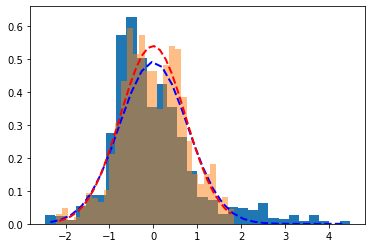

48 48 48 48


TypeError: getcov() got an unexpected keyword argument 'iy'

In [59]:
meansalesca = salearrayca.mean(axis=0)
stdsalesca = salearrayca.std(axis=0)
dd = (salearrayca - meansalesca).astype(float64)
dd /= stdsalesca
dd = dd.flatten()
iyear = 18


p0 = [dd.mean(), dd.std(), 0.1, 0.1, dd.std()]
ppnl = minimize(lambda x: tominyjfit(dd, x, fitbeta=False), p0,  options={'gtol': 1e-08, 'norm': np.inf, 'eps': 1.4901161193847656e-10,                                                                             'maxiter': 20000})
print(ppnl.x)

####################################


padl, padr = years.size, years.size
mu, sig, eta, eps, beta = ppnl.x
nl = np.array([eta, eps, beta])
# xpg = salearrayca-salearrayca.mean(axis=0)
xp = ((salearrayca - meansalesca)/stdsalesca).flatten()
xpg = to_gauss((xp.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)
xc = (casales - meansalesca)/stdsalesca
xcg = to_gauss((xc.astype('float64') - mu), nl)


bins, normed = 30, True
plt.hist(dd, bins=bins, normed=normed)
plt.hist(xpg.flatten(), bins=bins, normed=normed, alpha=0.5)
plt.plot(*fitgauss(dd, bins, normed), 'b--', lw=2, label='Fit Data')
plt.plot(*fitgauss(xpg.flatten(), bins, normed), 'r--', lw=2, label='Fit Transformed')

plt.show()

####################################
xpgpad = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
ff = np.fft.rfftfreq(xpgpad[0].size)
pk = []
for i in range(xpgpad.shape[0]): pk.append(psfunc(xpgpad[i]))
pk = np.array(pk)
pkm = pk.mean(axis=0)
tfpad = gettfprior(xpgpad[:, padl:-padr], padl, padr, al=0)
pkprior = pkm/tfpad
cov = getcov(pkprior, padl, padr, iy=iyear)
covca = cov.copy()
errg = cov.diagonal()**0.5

pkca = psfunc(np.pad(xcg, (padl, padr), mode='constant', constant_values=0))



p0 = np.ones(pkm.size*2)
chisqmin = lambda p: fourierposterior(p, xcg, pkprior, padl=padl, sigma=0.01, iyear=iyear)
pp = minimize(chisqmin, p0).x


capredg = fouriertox(pp)
deriv = (from_gauss(capredg*1.01, nl) - from_gauss(capredg*0.99, nl))/(capredg*0.02)
err = (errg*deriv)[padl:-padr] *stdsalesca

capredup = (from_gauss(capredg+errg, nl)[padl:-padr] + mu)*stdsalesca + meansalesca
capreddn = (from_gauss(capredg-errg, nl)[padl:-padr]+ mu)*stdsalesca + meansalesca
capred = (from_gauss(capredg, nl)[padl:-padr]+mu)*stdsalesca + meansalesca
casalesg = to_gauss((casales.astype('float64')-meansalesca )/stdsalesca-mu, nl)

In [ ]:
fsize = 13
plt.figure(figsize = (6.5, 4))

plt.errorbar(years, capred, err, color='C0', label='Prediction', lw=2, elinewidth=2)
# plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)

# Synth

In [ ]:
####################################

subdata = data[data['SubMeasureDesc'] == consumption]
predictors = pd.DataFrame(index = years[:iyear].astype(int), columns=statesid)
outcomes = pd.DataFrame(index = years.astype(int), columns=statesid)
costmatrix = []
for iy, yy in enumerate(years):
    outcomes.loc[int(yy)] = subdata[subdata['Year'] == yy]['Data_Value'].values.astype('float32')
    if iy<=iyear:
        predictors.loc[int(yy)] = subdata[subdata['Year'] == yy]['Data_Value'].values.astype('float32')
        costmatrix.append(costs[costs['Year'] == yy]['Data_Value'].values.astype('float32'))
predictors.loc['cost'] = np.array(costmatrix).mean(axis=0)*100
predictkeys = list(years[:iyear].astype(int))

iss, ss = 4, 'CA'
output = synth_tables( predictors,
               outcomes,
               ss,
               controlstates,
               predictkeys,
               list(years[:iyear].astype(int)),
               list(years.astype(int))
             )



In [ ]:
fsize = 13
plt.figure(figsize = (6.5, 4))

plt.errorbar(years, capred, err, color='C0', label='Prediction', lw=2, elinewidth=2)
plt.errorbar(years, output[0], color='C1', elinewidth=1, label='Synth', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)

# Factor Model Sim

In [ ]:
del iyear

In [60]:
np.random.seed(100)

In [131]:
meansalesca = salearrayca.mean(axis=0)
stdsalesca = 1#salearrayca.std(axis=0)
dd = (salearrayca - meansalesca).astype(float64)
dd /= stdsalesca
dd = dd.flatten()

p0 = [dd.mean(), dd.std(), 0.1, 0.1, dd.std()]
ppnl = minimize(lambda x: tominyjfit(dd, x, fitbeta=False), p0,  options={'gtol': 1e-08, 'norm': np.inf, 'eps': 1.4901161193847656e-10,                                                                             'maxiter': 20000})
print(ppnl.x)

####################################


# padl, padr = years.size, years.size
padl, padr = 0, 0
mu, sig, eta, eps, beta = ppnl.x
nl = np.array([eta, eps, beta])
# xpg = salearrayca-salearrayca.mean(axis=0)
xp = ((salearrayca - meansalesca)/stdsalesca).flatten()
xpg = to_gauss((xp.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)

xpgpad = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
ff = np.fft.rfftfreq(xpgpad[0].size)
pk = []
for i in range(xpgpad.shape[0]): pk.append(psfunc(xpgpad[i]))
pk = np.array(pk)
pkm = pk.mean(axis=0)
if padl:
    tfpad = gettfprior(xpgpad[:, padl:-padr], padl, padr, al=0)
else: tfpad = gettfprior(xpgpad, padl, padr, al=0)
pkprior = pkm/tfpad
noise = xpgpad.std(axis=0)**1 + 1e-6
cov = getcov(pkprior, padl, padr, i1=0, n0=noise)
covca = cov.copy()


[ 2.99021866e-04  2.70509856e+01  5.22387488e-02 -9.43273404e-02
  2.70502127e+01]
48 0 0 48


./scripts/yjtransform.py:129: RuntimeWarning: overflow encountered in multiply
  result = -0.5 * (x - mean) * hess * (x - mean)
./scripts/yjtransform.py:137: RuntimeWarning: invalid value encountered in add
  return (norm_logpdf(yy, np.zeros_like(mean), hess, normalized) + np.log(np.abs(to_gauss_g(xx - mean, nl)))).reshape(xx.shape)
./scripts/yjtransform.py:129: RuntimeWarning: overflow encountered in multiply
  result = -0.5 * (x - mean) * hess * (x - mean)
./scripts/yjtransform.py:137: RuntimeWarning: invalid value encountered in add
  return (norm_logpdf(yy, np.zeros_like(mean), hess, normalized) + np.log(np.abs(to_gauss_g(xx - mean, nl)))).reshape(xx.shape)


(array([ 20.,  26., 117., 621., 584., 313.,  71.,  52.,  12.,   8.]),
 array([-87.57289   , -68.01414244, -48.45539489, -28.89664734,
         -9.33789978,  10.22084777,  29.77959533,  49.33834288,
         68.89709043,  88.45583799, 108.01458554]),
 <a list of 10 Patch objects>)

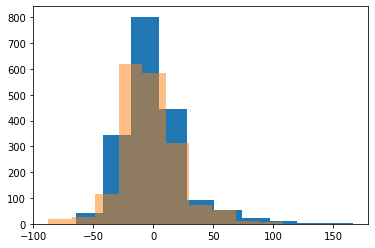

In [132]:
plt.hist(xp.flatten())
plt.hist(xpg.flatten(), alpha=0.5)

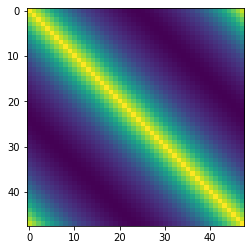

In [133]:
plt.imshow(covca);

In [134]:
eigs, eigv = np.linalg.eig(covca)
eigv = eigv.real

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


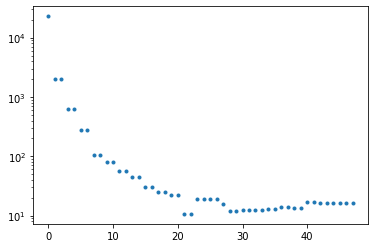

In [135]:
plt.plot(eigs, '.')
plt.yscale('log')

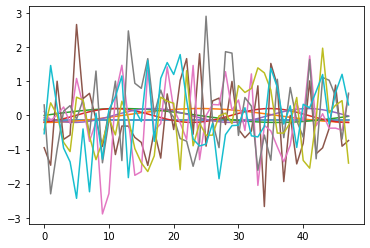

In [191]:
ii = 5
plt.plot(eigv[:, :ii])
plt.plot(eigv[:, :ii] + np.random.normal(size=eigv[:, :ii].size).reshape(eigv[:, :ii].shape))
# plt.plot(eig1)

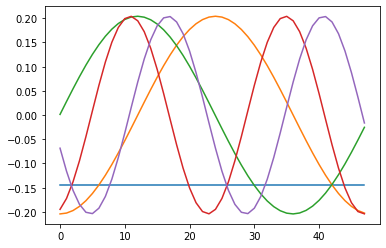

In [175]:
Nco, Ntr = 45, 5
T, T0 = 48, 30
nfactors = 5
ffactors = np.random.normal(size=T*nfactors).reshape(nfactors, T)
ffactors = eigv[:, :nfactors].T
plt.plot(ffactors.T)

def getload(treat, nf, w0=2*0.8*3**0.5, lnt0=-3**0.5, lnt1=3**0.5, lt0=3**0.5, lt1=3**1.5, getfixed=False):
    if getfixed : nf += 1
    if treat: return  np.random.uniform(lt0 - w0, lt1 - w0, size=nf)
#     if treat: return  np.random.uniform(lnt0, lnt1, size=nf)
    else: return  np.random.uniform(lnt0, lnt1, size=nf)
    

def simdata(Nco, Ntr, T, T0, nfactors, ffactors, getfixed=True):
    N = Nco + Ntr
    Y0, Y1, loads = [], [], []

    for i in range(N):

        if i < Ntr: 
            load = getload(True, nfactors, getfixed=getfixed)            
            treatment = np.zeros(T)
            treatment[T0:] = np.arange(1, T-T0+1) + np.random.normal(size=T-T0)            
        else:
            load = getload(False, nfactors, getfixed=getfixed)
            treatment = np.zeros(T)

        if getfixed: load, alpha = load[:-1], load[-1]
        else: alpha = 0
        loads.append(load)
        
        facwt = np.dot(ffactors.T, load)
        eps, xi = np.random.normal(size=T), np.random.normal(size=T)
        
        cov = np.zeros((nfactors, T))
        for j in range(nfactors):
            cov[j] = (1 + facwt + load.sum() + ffactors.sum(axis=0) + np.random.normal(size=T))
            
        covload = np.random.randint(1, 5, nfactors)
#         covload = np.array((1, 3))
        
        Y0.append(np.dot(cov.T, covload) + facwt + alpha + xi + 5 + eps)
        Y1.append(treatment + np.dot(cov.T, covload) + facwt + alpha + xi + 5 + eps)
    return np.array(Y0), np.array(Y1), np.array(loads)    
    
yy0, yy1, loads = simdata(Nco, Ntr, T, T0, nfactors, ffactors) 
yy = yy0.copy()
yy[0] = yy1[0]

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


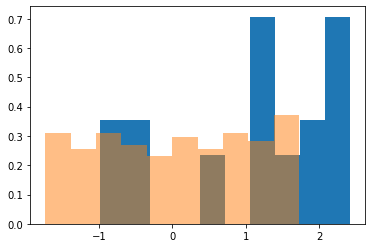

In [176]:
plt.hist(loads[:Ntr].flatten(), normed=True)
plt.hist(loads[Ntr:].flatten(), alpha=0.5, normed=True);

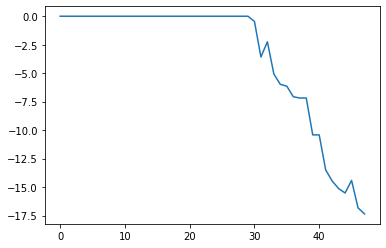

In [177]:
plot((yy0[0]-yy1[0]));

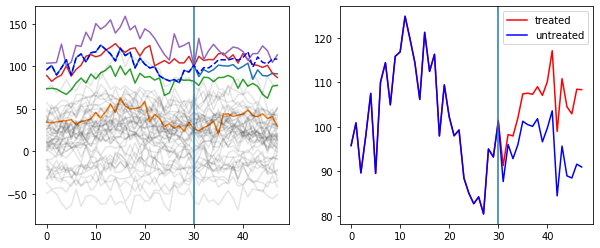

In [178]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(yy0[:Ntr].T)
plt.plot(yy0[Ntr:].T, 'k-', alpha=0.1)
plt.axvline(T0)
plt.plot(yy[0], 'b--')
plt.subplot(122)
plt.plot(yy1[0], 'r-', label='treated')
plt.plot(yy0[0], 'b-', label='untreated')
plt.axvline(T0)
plt.legend()
plt.show()

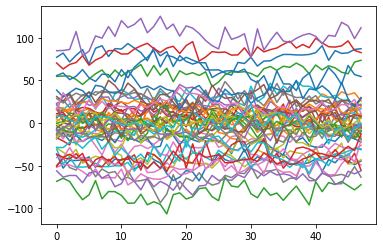

In [179]:
dd = yy1.copy()
mmean, sstd = dd.mean(axis=0), dd.std(axis=0)    
sstd = 1
dd = (dd - mmean)/sstd
plt.plot(dd.T)
plt.show()


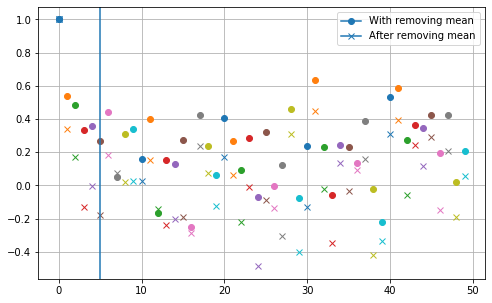

In [180]:
plt.figure(figsize=(8, 5))
for ii in range(yy.shape[0]):
    plt.plot(ii, np.corrcoef(yy[0], yy[ii])[0, 1], 'C%d'%ii, marker='o')
    plt.plot(ii, np.corrcoef(yy[0]-yy.mean(axis=0), yy[ii]-yy.mean(axis=0))[0, 1], 'C%d'%ii, marker='x')
for ii in range(1):
    plt.plot(ii, np.corrcoef(yy[0], yy[ii])[0, 1], 'C%d'%ii, marker='o', label='With removing mean')
    plt.plot(ii, np.corrcoef(yy[0]-yy.mean(axis=0), yy[ii]-yy.mean(axis=0))[0, 1], 'C%d'%ii, marker='x', label='After removing mean')
plt.axvline(5)
plt.legend()
plt.grid()

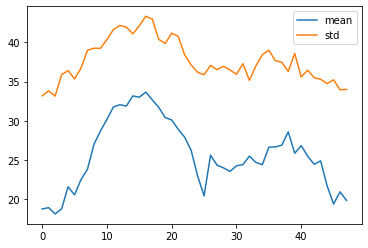

In [181]:
plt.plot(yy.mean(axis=0), label='mean')
plt.plot(yy.std(axis=0), label='std')
plt.legend()

# Our method on sim

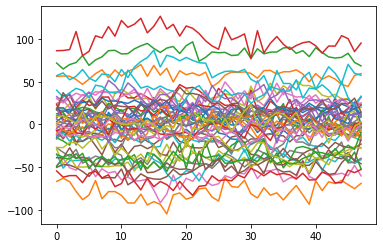

[-6.13725889e-01  3.25477691e+01 -5.14846159e-01 -1.02418660e-02
  3.53112351e+01]


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


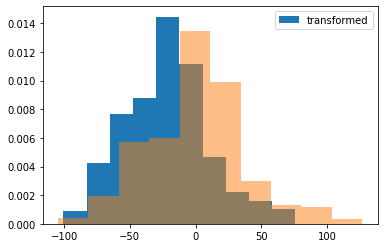

In [182]:
def transform(alldata, idata=None, index=0, stdscale=False, fitbeta=False, p0=None):
    if idata is None:
        idata = alldata[0]
        dd = alldata[1:]
    else: dd = alldata
        
    mmean, sstd = dd.mean(axis=0), dd.std(axis=0)    
    if not stdscale : sstd = 1
    dd = (dd - mmean)/sstd
    plt.plot(dd.T)
    plt.show()
    
    if p0 is None: p0 = [dd.mean(), dd.std(), 0.1, 0.1, dd.std()]
    ppnl = minimize(lambda x: tominyjfit(dd.flatten(), x, fitbeta=fitbeta), p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10,                                                                             'maxiter': 20000})
#     ppnl = minimize(lambda x: tominyjfit(dd.flatten(), x, fitbeta=False), p0, method='Nelder-Mead',
#                     options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10,                                                                             'maxiter': 20000})
    print(ppnl.x)

    mu, sig, eta, eps, beta = ppnl.x
    nl = np.array([eta, eps, beta])
    # xpg = salearrayca-salearrayca.mean(axis=0)
    xp = ((dd - mmean)/sstd).flatten()
    xpg = to_gauss((xp.astype('float64') - mu), nl).reshape(dd.shape[0], -1)
    xc = (idata - mmean)/sstd
    xcg = to_gauss((xc.astype('float64') - mu), nl)

    return [ppnl.x, mmean, sstd], [xpg, xcg], [dd, idata]


params, gdata, ddata = transform(yy, stdscale=False, fitbeta=True)

plt.hist(gdata[0].flatten(), normed=True, label='transformed')
plt.hist(ddata[0].flatten(), alpha=0.5, normed=True);
plt.legend()
# plt.hist(yy1.flatten(), alpha=0.5)
# ####################################



In [183]:
####################################
padl, padr = T, T
timep = np.arange(T)
xpg = gdata[0]
xcg = gdata[1]
mu, sig, eta, eps, beta = params[0]
nl = np.array([eta, eps, beta])


xpgpad = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
ff = np.fft.rfftfreq(xpgpad[0].size)
pk = []
for i in range(xpgpad.shape[0]): pk.append(psfunc(xpgpad[i]))
pk = np.array(pk)
pkm = pk.mean(axis=0)
tfpad = gettfprior(xpgpad[:, padl:-padr], padl, padr, al=0)
pkprior = pkm/tfpad
cov = getcov(pkprior, padl, padr, i1=T0)
errg = cov.diagonal()**0.5

pkca = psfunc(np.pad(xcg, (padl, padr), mode='constant', constant_values=0))


p0 = np.ones(pkm.size*2)
chisqmin = lambda p: fourierposterior(p, xcg, pkprior, padl=padl, sigma=0.01, iyear=T0)
pp = minimize(chisqmin, p0).x


predg = fouriertox(pp)


deriv = (from_gauss(predg*1.01, nl) - from_gauss(predg*0.99, nl))/(predg*0.02)
err = (errg*deriv)[padl:-padr] *params[-1]

predup = (from_gauss(predg+errg, nl)[padl:-padr] + mu)*params[-1] + params[-2]
preddn = (from_gauss(predg-errg, nl)[padl:-padr]+ mu)*params[-1] + params[-2]
pred = (from_gauss(predg, nl)[padl:-padr]+mu)*params[-1] + params[-2]


48 48 48 48


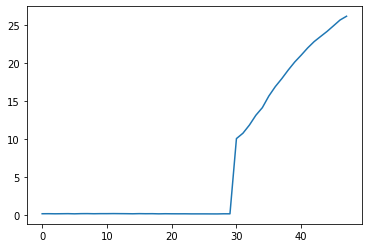

In [184]:
plt.plot(err)

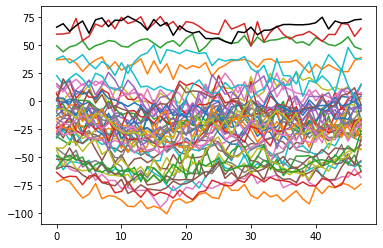

In [185]:
plt.plot(gdata[0].T)
plt.plot(gdata[1], 'k')
# plt.loglog()

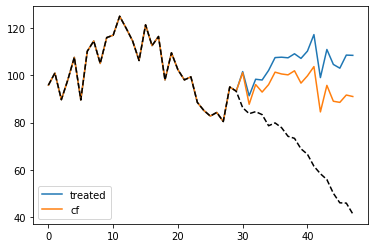

In [186]:
plt.plot(yy1[0], label='treated')
plt.plot(yy0[0], label='cf')
plt.plot(pred, 'k--')
plt.legend()

# Synth on sim

In [187]:
####################################

predictors = pd.DataFrame(index = np.arange(T0), columns=np.arange(Nco+Ntr))
outcomes = pd.DataFrame(index = timep, columns=np.arange(Nco+Ntr))
for iy in np.arange(T):
    outcomes.loc[int(iy)] = yy[:, iy]#subdata[subdata['Year'] == yy]['Data_Value'].values.astype('float32')
    if iy<=T0:
        predictors.loc[int(iy)] = yy[:, iy]#subdata[subdata['Year'] == yy]['Data_Value'].values.astype('float32')

predictkeys = list(np.arange(T0).astype(int))

iss, ss = 0, 0
output = synth_tables( predictors,
               outcomes,
               ss,
               np.arange(1, Nco+Ntr),
               predictkeys,
               list(np.arange(T0).astype(int)),
               list(np.arange(T).astype(int))
             )




Do data prep

No exception
Use predictors
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 103.50775299809663
            Iterations: 9
            Function evaluations: 473
            Gradient evaluations: 9


Text(0.5, 1.0, 'Difference from true cf')

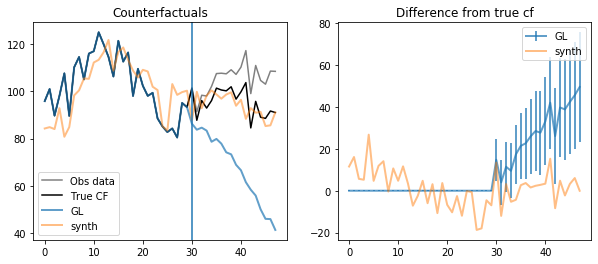

In [188]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
# plt.plot(yy[0], 'r--')
plt.plot(yy1[0], 'gray', label='Obs data')
plt.plot(yy0[0], 'k', label='True CF')
plt.plot(pred, lw=2, alpha=0.7, label='GL')
plt.plot(output[0], lw=2, alpha=0.5,  label='synth')
plt.axvline(T0)
plt.legend()
plt.title('Counterfactuals')

plt.subplot(122)
# plt.plot(yy1[0], 'gray', label='Obs data')
plt.errorbar(np.arange(T), yy0[0]-pred, err, lw=2, alpha=0.7, label='GL')
plt.errorbar(np.arange(T), yy0[0]-output[0], lw=2, alpha=0.5,  label='synth')
plt.legend()
plt.title('Difference from true cf')

In [189]:
output[5].sum()

1.000000097329174

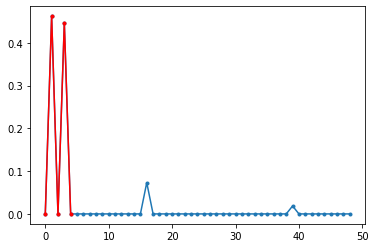

In [190]:
plt.plot(output[5], marker='.')
plt.plot(output[5][:5], color='r', marker='.')

# plt.yscale('log')

# sim results

In [173]:
t = []
for i in range(1000):
    try: t.append(np.loadtxt('./scripts/output_sim/nopropensity//cf-%d.txt'%i))
#     try: t.append(np.loadtxt('./scripts/output_sim/test/cf-%d.txt'%i))
    except: pass
t = np.array(t)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

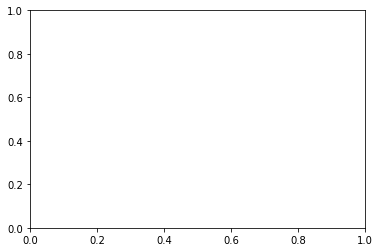

In [174]:
diffsynth = t[...,1] - t[...,2]
diffgl = t[...,1] - t[...,3]

def bootstrap(x, B=1000):
    n = x.shape[0]
    bs = []
    for i in range(B):
        bs.append(x[np.random.randint(0, n, n)].mean(axis=0))
    return np.array(bs).std(axis=0)

# plt.errorbar(np.arange(T), diffsynth.mean(axis=0), diffsynth.std(axis=0))
# plt.errorbar(np.arange(T), diffgl.mean(axis=0), diffgl.std(axis=0))

plt.errorbar(np.arange(T), diffsynth.T.mean(axis=1), bootstrap(diffsynth), label='synth');
plt.errorbar(np.arange(T), diffgl.T.mean(axis=1), bootstrap(diffgl), label='gl');
# plt.errorbar(np.arange(T), diffgl.T.mean(axis=1), (t[...,1] - t[...,3]).T.std(axis=1)/sqrt(t.shape[0]), label='gl');
plt.legend()
plt.title('Avg bias of 100 samples')

In [249]:
np.correlate(ffactors[0], ffactors[0], 'full')

array([ 0.53000171, -0.79336596, -0.79706292, -2.85770631, -2.04442592,
       -0.6931936 , -0.91841749,  2.92121366, -0.93493469,  4.17174575,
        0.23524865,  5.031601  , -0.62877115,  1.68896838,  3.89620965,
       -0.37555376,  3.91838516, -0.88579133, 12.43681399, -2.03608459,
        5.91909606, -7.88716247,  0.43552356, -8.62825218, -3.64070939,
        4.16355127, -3.52708087,  9.54614659,  5.39401177, 33.83151599,
        5.39401177,  9.54614659, -3.52708087,  4.16355127, -3.64070939,
       -8.62825218,  0.43552356, -7.88716247,  5.91909606, -2.03608459,
       12.43681399, -0.88579133,  3.91838516, -0.37555376,  3.89620965,
        1.68896838, -0.62877115,  5.031601  ,  0.23524865,  4.17174575,
       -0.93493469,  2.92121366, -0.91841749, -0.6931936 , -2.04442592,
       -2.85770631, -0.79706292, -0.79336596,  0.53000171])

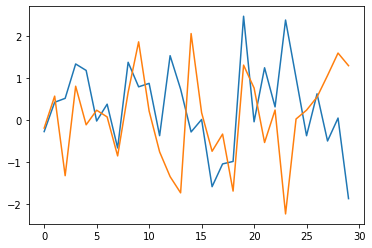

In [246]:
plt.plot(ffactors.T)

In [252]:
cov.shape

(90, 90)